<a href="https://colab.research.google.com/github/peeush-agarwal/week-based-learning/blob/master/Deep-Learning/RNNs/CharacterLevelRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character Level RNN tutorial

## Goal

The purpose of this tutorial is to train a RNN model which learns language from give names and then able to predict language for specific name.

## Download dataset

+ Download dataset from [here](https://download.pytorch.org/tutorial/data.zip)
+ Dataset consists of text files for each language
+ Each text file contains names in each line

In [1]:
! unzip '/content/drive/My Drive/Colab Notebooks/data.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


## Import required libraries

In [0]:
import os
import glob
from io import open
import unicodedata
import string
import random

import torch
import torch.nn as nn
import torch.optim as optim

## Data preprocessing

In [0]:
base_path = 'data/names'

In [4]:
# all_letters is the vocabulary which our model trains on.
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [5]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


### Prepare dictionary of "Language":"List of all names" by reading from all files

In [0]:
all_categories = []
category_line = {}
for data_file in glob.glob(base_path+'/*.txt'):
  category = os.path.splitext(os.path.basename(data_file))[0]
  all_categories.append(category)
  lines = open(data_file).read().strip().split('\n')
  category_line[category] = [unicodeToAscii(line) for line in lines]
n_categories = len(all_categories)

In [12]:
print(n_categories)
for k, v in category_line.items():
  print(f"{k}: {len(v)} - {', '.join(v[:5])}")

18
Czech: 519 - Abl, Adsit, Ajdrna, Alt, Antonowitsch
French: 277 - Abel, Abraham, Adam, Albert, Allard
Greek: 203 - Adamidis, Adamou, Agelakos, Akrivopoulos, Alexandropoulos
Russian: 9408 - Ababko, Abaev, Abagyan, Abaidulin, Abaidullin
Vietnamese: 73 - Nguyen, Tron, Le, Pham, Huynh
Arabic: 2000 - Khoury, Nahas, Daher, Gerges, Nazari
Irish: 232 - Adam, Ahearn, Aodh, Aodha, Aonghuis
Scottish: 100 - Smith, Brown, Wilson, Campbell, Stewart
Chinese: 268 - Ang, AuYong, Bai, Ban, Bao
German: 724 - Abbing, Abel, Abeln, Abt, Achilles
Korean: 94 - Ahn, Baik, Bang, Byon, Cha
Japanese: 991 - Abe, Abukara, Adachi, Aida, Aihara
Portuguese: 74 - Abreu, Albuquerque, Almeida, Alves, Araujo
Spanish: 298 - Abana, Abano, Abarca, Abaroa, Abascal
Dutch: 297 - Aalsburg, Aalst, Aarle, Achteren, Achthoven
Polish: 139 - Adamczak, Adamczyk, Andrysiak, Auttenberg, Bartosz
Italian: 709 - Abandonato, Abatangelo, Abatantuono, Abate, Abategiovanni
English: 3668 - Abbas, Abbey, Abbott, Abdi, Abel


### Convert names to One-hot representation tensors

In [7]:
def charToTensor(c):
  tensor = torch.zeros((1, n_letters))
  tensor[0][all_letters.find(c)] = 1
  return tensor

print(charToTensor('b'))
print(charToTensor('b').shape)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])


In [8]:
def wordToTensor(word):
  tensor = torch.empty((len(word), 1, n_letters))
  for id, char in enumerate(word, 0):
    tensor[id] = charToTensor(char)
  return tensor

print(wordToTensor('Alb').shape)
print(wordToTensor('Alb'))

torch.Size([3, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


## Build a RNN model

In [0]:
class CharLevel_RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(CharLevel_RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    self.softmax = nn.LogSoftmax(dim = 1)
  
  def forward(self, input, hidden_state):
    combined = torch.cat((input, hidden_state), dim=1)
    hidden = self.i2h(combined)
    output = self.softmax(self.i2o(combined))
    return output, hidden
  
  def init_hidden(self):
    return torch.zeros((1, self.hidden_size))

### Initialize RNN model

In [0]:
n_hidden = 128
model = CharLevel_RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
lr = 0.001
# optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
initial_hidden = model.init_hidden()

### Prepare helper function to get category from output tensor

In [0]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  category = all_categories[category_i]
  return category, category_i

### Examples to run RNN model

#### Run RNN model for character 'A'

In [18]:
input_tensor = charToTensor('A')
output, hidden_state = model(input_tensor, initial_hidden)

print(output)
print(hidden_state.size())
categoryFromOutput(output)

tensor([[-2.8837, -2.8982, -2.9221, -2.9845, -2.7632, -2.9916, -2.9388, -2.8066,
         -2.8038, -2.9483, -2.9181, -2.8900, -2.8723, -2.8821, -2.8282, -2.8570,
         -2.8738, -3.0021]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])


('Vietnamese', 4)

#### Run RNN model for name='Albert'

In [19]:
name = 'Albert'

name_tensor = wordToTensor(name)
hidden_state = model.init_hidden()
for idx in range(name_tensor.size()[0]):
  input_tensor = name_tensor[idx]
  output, hidden_state = model(input_tensor, hidden_state)

  print(output)
  print(hidden_state.size())

tensor([[-2.8837, -2.8982, -2.9221, -2.9845, -2.7632, -2.9916, -2.9388, -2.8066,
         -2.8038, -2.9483, -2.9181, -2.8900, -2.8723, -2.8821, -2.8282, -2.8570,
         -2.8738, -3.0021]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])
tensor([[-2.8962, -2.9585, -2.8766, -2.9094, -2.8525, -2.8992, -2.9320, -2.8673,
         -2.7431, -2.9398, -2.8934, -2.9538, -2.8362, -2.9346, -2.9232, -2.8881,
         -2.8313, -2.9156]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])
tensor([[-2.9842, -2.9014, -2.7856, -2.8355, -2.8423, -2.9946, -2.7635, -2.8797,
         -2.8475, -2.9726, -2.9014, -2.9717, -2.7796, -2.9090, -2.9457, -2.9414,
         -2.8597, -2.9573]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])
tensor([[-2.9473, -2.9635, -2.7946, -2.9562, -2.7484, -2.8982, -2.9030, -2.8570,
         -2.7089, -3.0168, -2.9805, -3.0007, -2.7763, -2.9220, -2.9056, -2.8873,
         -2.9029, -2.9230]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])
tensor([[-2.8412, -2.9521, -2.82

### Helper function to get random training example to train the RNN model

In [20]:
def randomChoice(l):
  return l[random.randint(0, len(l) -1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  name = randomChoice(category_line[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  name_tensor = wordToTensor(name)
  return category, name, category_tensor, name_tensor

for i in range(5):
  category, name, category_tensor, name_tensor = randomTrainingExample()
  print(f'{category}:{name}')
  print(category_tensor)
  print(name_tensor.size())

Korean:Hyun 
tensor([10])
torch.Size([5, 1, 57])
German:Groos
tensor([9])
torch.Size([5, 1, 57])
Irish:Milligan
tensor([6])
torch.Size([8, 1, 57])
Czech:Jirku
tensor([0])
torch.Size([5, 1, 57])
Korean:Cha
tensor([10])
torch.Size([3, 1, 57])


### Helper function to train model for one name tensor

In [0]:
def train(name_tensor, category_tensor):
  hidden_state = model.init_hidden()

  model.zero_grad()

  for i in range(name_tensor.size()[0]):
    output, hidden_state = model(name_tensor[i], hidden_state)
  
  loss = criterion(output, category_tensor)
  loss.backward()

  for p in model.parameters():
    p.data.add_(-lr, p.grad.data)
  
  return output, loss.item()

#### Example to run train for random training example

In [22]:
category, name, category_tensor, name_tensor = randomTrainingExample()
print(name, category)
output, loss = train(name_tensor, category_tensor)
print(output, loss)

Qiu Chinese
tensor([[-2.8828, -2.9242, -2.8554, -2.8917, -2.8358, -2.9369, -2.8671, -2.8437,
         -2.7301, -2.9951, -2.9387, -2.9775, -2.8680, -2.9038, -2.8785, -2.9261,
         -2.8930, -2.9083]], grad_fn=<LogSoftmaxBackward>) 2.7300899028778076


### Train the model

In [26]:
import time
import math

n_iterations = 500000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

model.train()

for i in range(n_iterations):
  category, name, category_tensor, name_tensor = randomTrainingExample()
  output, loss = train(name_tensor, category_tensor)
  current_loss += loss

  # Print iter number, loss, name and guess
  if i % print_every == 0:
      guess, guess_i = categoryFromOutput(output)
      correct = '✓' if guess == category else '✗ (%s)' % category
      print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iterations * 100, timeSince(start), loss, name, guess, correct))

  # Add current loss avg to list of losses
  if i % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0

0 0% (0m 0s) 2.9356 Vo / Italian ✗ (Vietnamese)
5000 1% (0m 7s) 2.9501 Tonks / Greek ✗ (English)
10000 2% (0m 14s) 2.9706 Hor / Scottish ✗ (Chinese)
15000 3% (0m 21s) 2.7929 Noh / Greek ✗ (Korean)
20000 4% (0m 28s) 1.8218 Sfakianos / Greek ✓
25000 5% (0m 36s) 2.8909 Gray / Chinese ✗ (Scottish)
30000 6% (0m 43s) 3.0491 Kauphsman / Russian ✗ (Czech)
35000 7% (0m 50s) 2.6882 Sarkozi / Italian ✗ (French)
40000 8% (0m 57s) 3.0141 Longhurst / Russian ✗ (English)
45000 9% (1m 4s) 2.5275 Gensai / Arabic ✗ (Japanese)
50000 10% (1m 12s) 2.1938 Hierro / Portuguese ✗ (Spanish)
55000 11% (1m 19s) 1.2855 Kartoshkin / Russian ✓
60000 12% (1m 26s) 2.2355 Bisset / German ✗ (French)
65000 13% (1m 33s) 0.8188 Yan / Chinese ✓
70000 14% (1m 40s) 4.0229 Calligaris / Greek ✗ (Italian)
75000 15% (1m 48s) 2.0235 Frei / German ✓
80000 16% (1m 55s) 1.1853 Wirner / German ✓
85000 17% (2m 2s) 0.3090 Drivakis / Greek ✓
90000 18% (2m 9s) 0.7384 Safar / Arabic ✓
95000 19% (2m 17s) 1.2139 Kassis / Greek ✗ (Arabic)
100

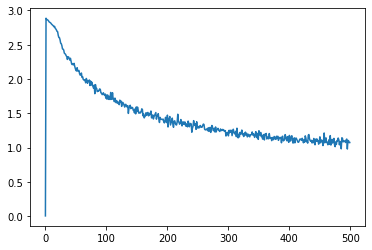

In [27]:
import matplotlib.pyplot as plt

plt.plot(all_losses)
plt.show()